https://github.com/dpmlab/Anticipation-of-temporally-structured-events/blob/8fbd488c04d47148f9a53048de5d05a90e1c1663/s_light.py#L311

# Import Libraries

In [2]:
import os
import pickle
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split
import nibabel as nib

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, ttest_1samp
from statsmodels.stats.multitest import multipletests

from nilearn import plotting, image
from nibabel.viewers import OrthoSlicer3D

from scipy.stats import norm

# Helper Functions

## 2D Maps (repeat, vox)

In [6]:
def create_2d_vox_map(sl_timescales):

    # Number of valid voxels
    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    coords = np.transpose(np.where(non_nan_mask))
    nVox = coords.shape[0]

    nMaps = 6  # Number of movie repeats

    # Indices of voxels belonging to each searchlight
    SL_voxels = pickle.load(open('../data/SL/SL_allvox.p', 'rb'))

    # Arrays for voxel maps and voxel searchlight count
    vox_map_2d = np.zeros((nMaps, nVox))
    voxel_SLcount = np.zeros(nVox)

    # Iterate over searchlights and voxels
    for sl_idx, voxels_per_sl in enumerate(SL_voxels):
        for m in range(nMaps):
            vox_map_2d[m, voxels_per_sl] += sl_timescales[str(sl_idx)][m] # voxel gets all its sl contributions

        # Increment the count of searchlights for each voxel
        voxel_SLcount[voxels_per_sl] += 1

    # Identify non-zero voxel counts
    nz_vox = voxel_SLcount > 0

    # Calculate voxel means based on searchlight contributions
    vox_map_2d[:, nz_vox] = vox_map_2d[:, nz_vox] / voxel_SLcount[nz_vox]

    # Set values for voxels with no searchlight contribution to NaN
    vox_map_2d[:, ~nz_vox] = np.nan

    return vox_map_2d

## 4D Maps (X,Y,Z,repeat)

In [ ]:
def create_4d_vox_map(vox_map_2d):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    vox_map_4d = np.zeros((Z,Y,X,6))
    vox_map_4d[non_nan_mask] = vox_map_2d.T

    return vox_map_4d

## One vs. Other

In [3]:
def one_vs_other(vox_map_4d, template):

    # The first voxel map for movie repeat #1
    group1 = vox_map_4d[:,:,:,0]

    # Average of the rest of the voxel maps for movie repeats [2,6]
    group2 = np.mean(vox_map_4d[:,:,:,1:], axis = 3)

    OvO = group2 - group1

    OvO_img = nib.Nifti1Image(OvO.T, affine=template.affine, header=template.header)

    return OvO_img

# meeting, which repeat is which, for each person, 
# upgrade to faster server, or split participants
# we mess up which one is the first one for each person
# might need to use cluster


## Correlation | timescales & range

In [11]:
def corr_timescales_range(vox_map_2d, template):

    non_nan_mask = nib.load('../data/valid_vox.nii').get_fdata().T > 0
    X,Y,Z = non_nan_mask.shape

    # Reference vector
    ref_vector = np.array([1, 2, 3, 4, 5, 6])

    # Initialize array to store the correlation coefficients
    correlation_map = np.zeros(vox_map_2d.shape[1])

    # Corr for each voxel
    for i in range(vox_map_2d.shape[1]):
        correlation_map[i], _ = pearsonr(vox_map_2d[:, i], ref_vector)

    # Reshape corr map back to 3D
    corr = np.zeros((Z,Y,X))
    corr[non_nan_mask] = correlation_map

    corr_img = nib.Nifti1Image(corr.T, affine=template.affine, header=template.header)

    return corr_img

# Analysis: Test

In [40]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./intact_maps/WBC/WBC.npy', allow_pickle=True).item()

In [42]:
# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

In [43]:
# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

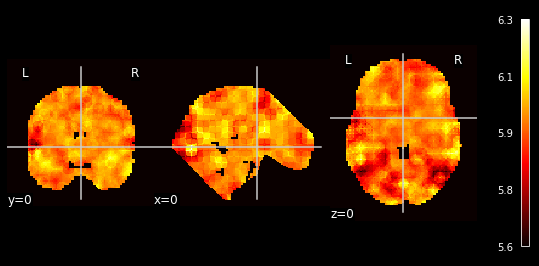

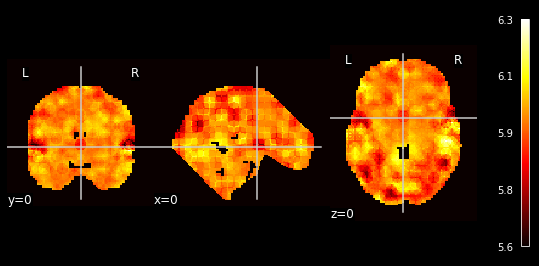

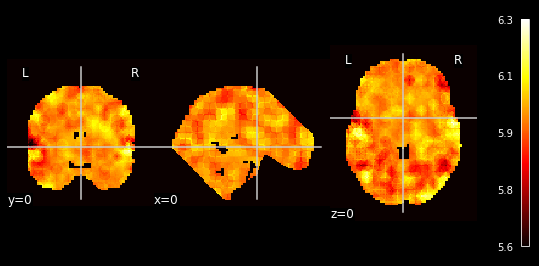

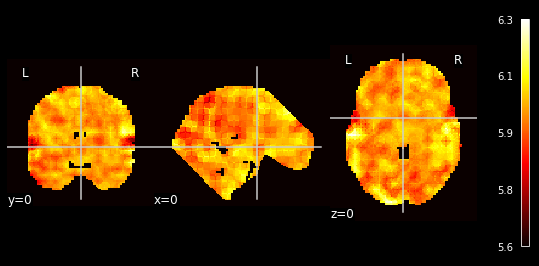

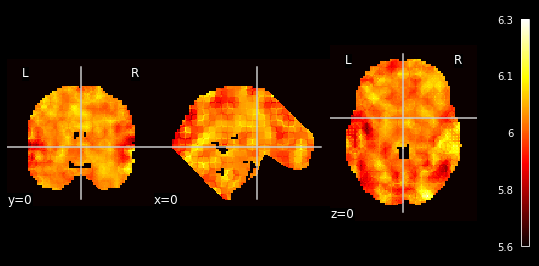

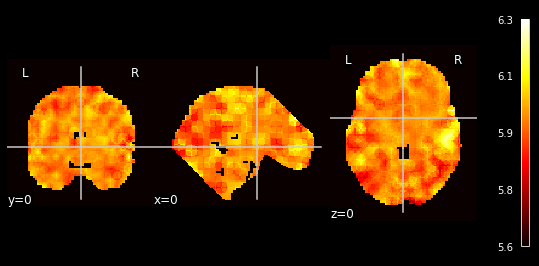

In [49]:
# visualize maps
for i in range(6):
    values = vox_map_4d[:,:,:,i]

    img = nib.Nifti1Image(values.T, affine=template.affine, header=template.header)
    #nib.save(img, f'./intact_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True, vmin=5.6)

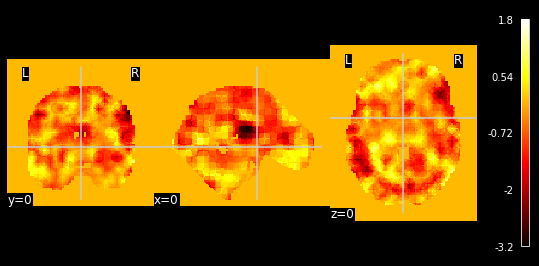

In [19]:
# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
#nib.save(OvO_img , './intact_maps/LL/OvO_LL.nii')

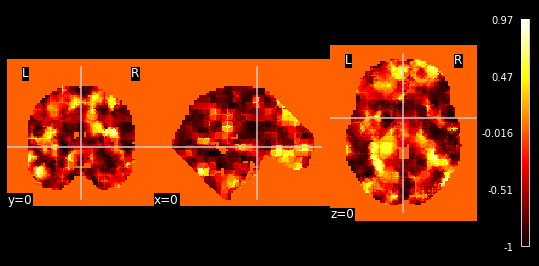

In [20]:
# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
#nib.save(corr_img, './intact_maps/LL/corr_LL.nii')

# Analysis: Intact

## LL

In [ ]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./intact_maps/LL/LL.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./intact_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './intact_maps/LL/OvO_LL.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './intact_maps/LL/corr_LL.nii')

## WBC

In [16]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./intact_maps/WBC/WBC.npy', allow_pickle=True).item()

In [18]:
# create 2d voxel map [repeat x voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

In [19]:
# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

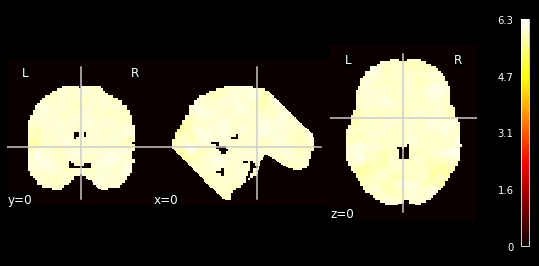

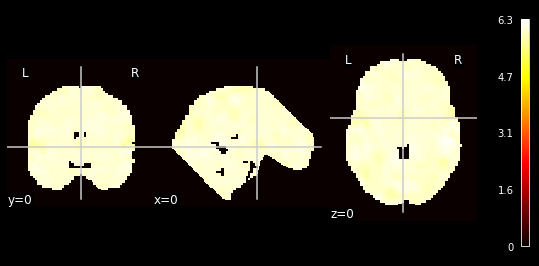

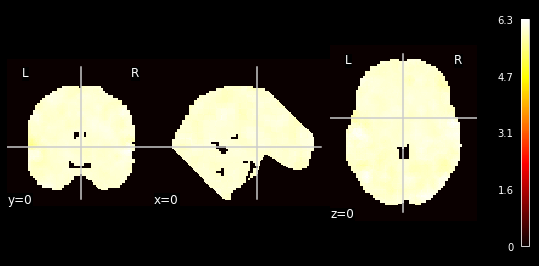

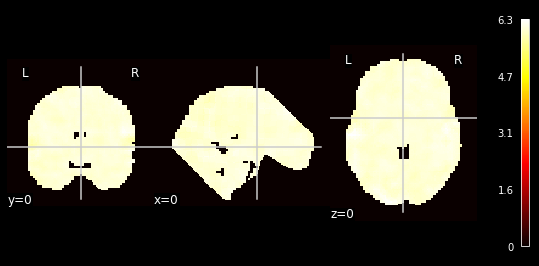

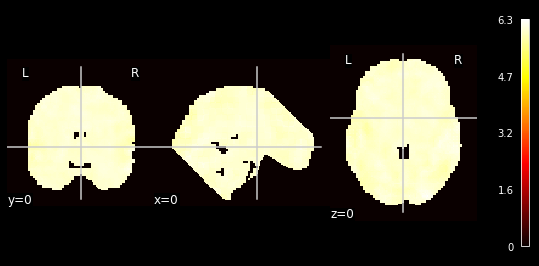

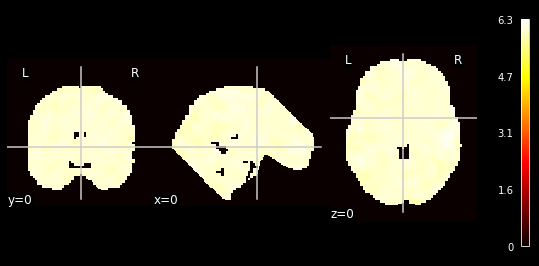

In [20]:
# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./intact_maps/WBC/WBC_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], 
                  black_bg=True, colorbar=True)

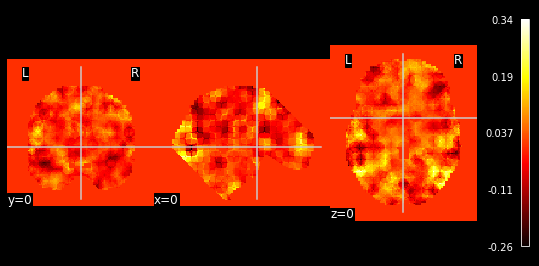

In [21]:
# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './intact_maps/WBC/OvO_WBC.nii')

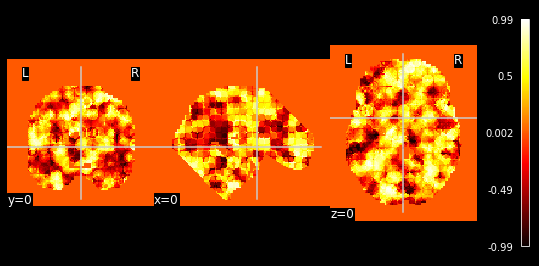

In [22]:
# get correlations between vox timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './intact_maps/WBC/corr_WBC.nii')

# Analysis: Scrambled

## LL

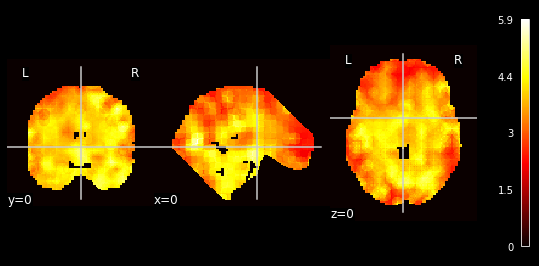

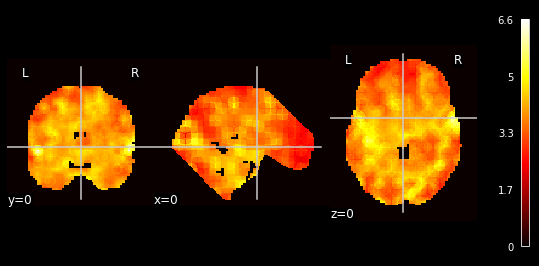

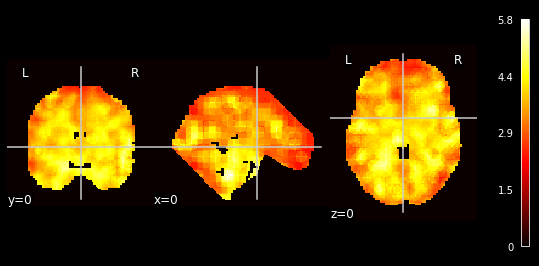

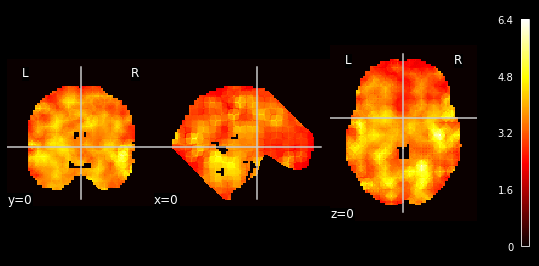

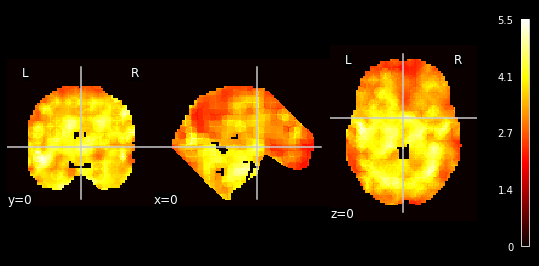

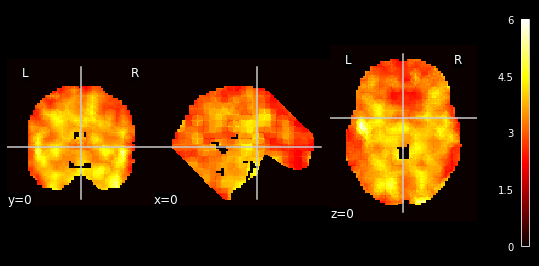

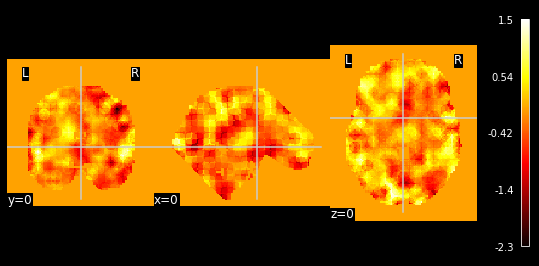

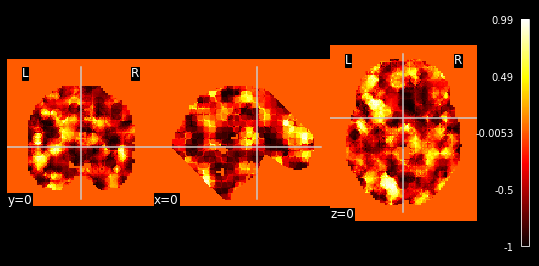

In [7]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./scrambled_maps/LL/LL.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./scrambled_maps/LL/LL_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './scrambled_maps/LL/OvO_LL.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './scrambled_maps/LL/corr_LL.nii')

## WBC

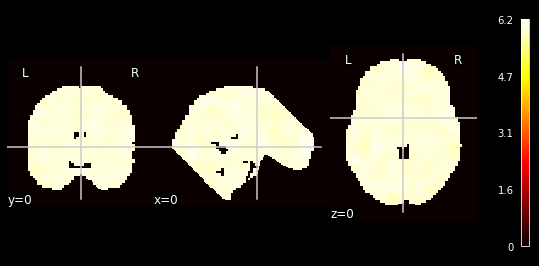

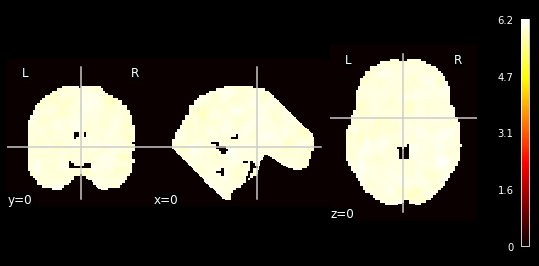

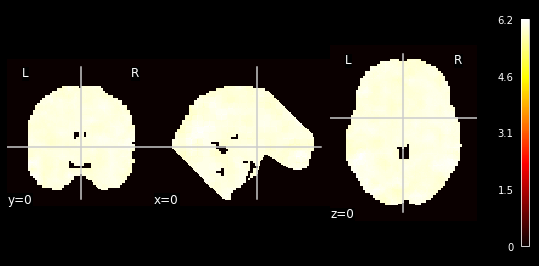

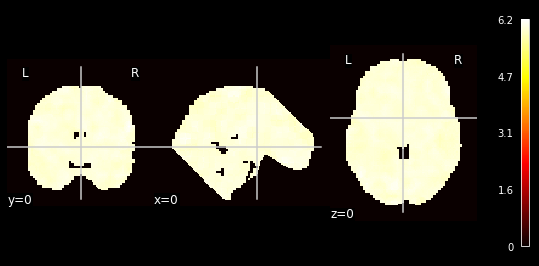

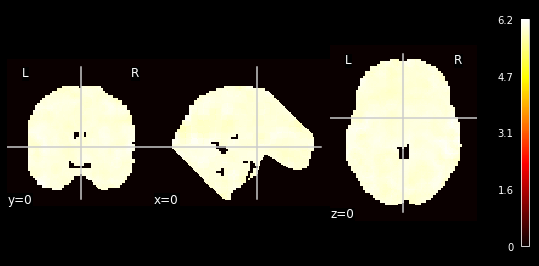

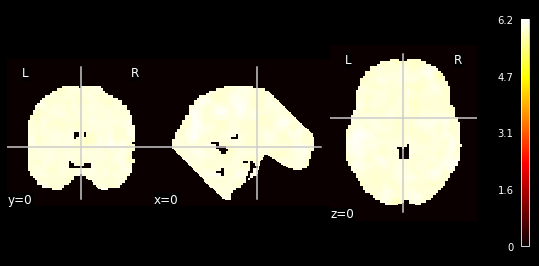

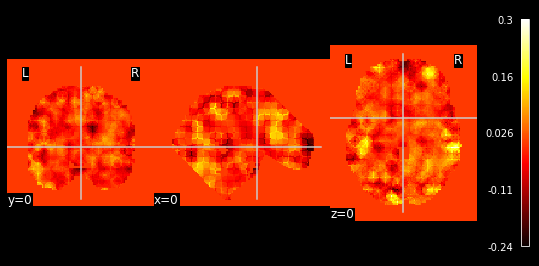

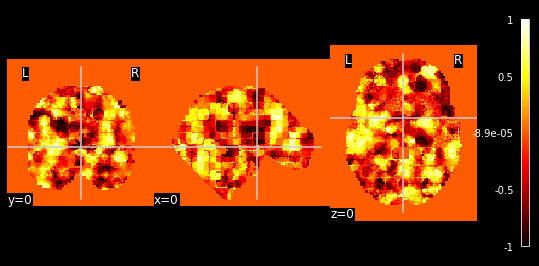

In [8]:
# template
header_fpath = '../data/0407161_predtrw02/filtFuncMNI_Intact_Rep1.nii'
template = nib.load(header_fpath)

# load eWBC.npy file / dictionary 
sl_timescales = np.load('./scrambled_maps/WBC/WBC.npy', allow_pickle=True).item()

# create 2d voxel map [repeat, voxel]
vox_map_2d = create_2d_vox_map(sl_timescales)

# create 4d voxel map [Z,Y,X,repeat]
vox_map_4d = create_4d_vox_map(vox_map_2d)

# visualize maps
for i in range(6):
    img = nib.Nifti1Image(vox_map_4d[:,:,:,i].T, affine=template.affine, header=template.header)
    nib.save(img, f'./scrambled_maps/WBC/WBC_repeat{i}.nii')

    plotting.plot_img(img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)

# do one vs. other analysis
OvO_img = one_vs_other(vox_map_4d, template)
plotting.plot_img(OvO_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(OvO_img , './scrambled_maps/WBC/OvO_WBC.nii')

# get correlations between voxel timescales and range[1,6]
corr_img = corr_timescales_range(vox_map_2d, template)
plotting.plot_img(corr_img, cmap='hot', display_mode='ortho', cut_coords=[0, 0, 0], black_bg=True, colorbar=True)
nib.save(corr_img, './scrambled_maps/WBC/corr_WBC.nii')

# Drafts

## Null LLs for All Scrambled

In [ ]:
import os
import time
import numpy as np
import deepdish as dd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import pearsonr
from brainiak.eventseg.event import EventSegment
from sklearn.model_selection import train_test_split

# Directory containing .h5 files
directory_path = '../data/SL/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.h5')]

test_size = 0.5
nEvents = np.arange(2,11)

n=0

areas_LLs = {}

for file in h5_files:

    # Construct the full file path
    ti = time.time()
    file_path = os.path.join(directory_path, file)
    area_name = file.split('.')[0]
    
    # Load the data from the .h5 file
    D_orig = dd.io.load(file_path)
    vox_N = D_orig[list(D_orig.keys())[0]]['Intact'].shape[2]
    D = np.zeros((30, 6, 60, vox_N))
    for i, s in enumerate(D_orig.keys()):
        D[i] = D_orig[s]['Intact']

    G = D.mean(0)

    N_subj = D.shape[0]

    LLs = np.empty((len(nEvents),6, 2), dtype=object)

    num_timepoints = G.shape[1]

    for ev_i, ev in enumerate(nEvents):
        for repeat in range(6):

            sum_LL = 0

            train_indices, test_indices = train_test_split(np.arange(N_subj),
                                                test_size=test_size, 
                                                random_state=42)

            train = D[train_indices].mean(0)
            test  = D[test_indices].mean(0)

            hmm = EventSegment(ev, split_merge=True)                
            hmm.fit(train[repeat])

            # meeting scramble = True, should fail, when the model doesn't work, 50 times or nulls
            _, LL = hmm.find_events(test[repeat])
            LLs[ev_i, repeat, 0] = LL

            scrambled = []
            for i in range(50):
                _, LL = hmm.find_events(test[repeat], scramble=True)
                scrambled.append(LL)

            LLs[ev_i, repeat, 1] = scrambled
            
    areas_LLs[area_name] = LLs

    n = n+1
    tf = time.time()
    print(n)
    print((tf-ti)/60)


# Save data to .npy file
np.save(f'./intact_maps/LL/scrambled_ll_0.npy', areas_LLs)


## Prepare dataset

In [4]:
# Directory containing .h5 files
directory_path = '../data/SL/'
h5_files = [file.split('.')[0] for file in os.listdir(directory_path) if file.endswith('.h5')]


# Done files:
npy_directory_path = './intact_maps/LL/scrambled_ll/'
npy_files = [file.split('.')[0] for file in os.listdir(npy_directory_path) if file.endswith('.npy')]


# Test
print(len(h5_files))
print(len(npy_files))

5354
5354


In [7]:
# Directory containing .h5 files
directory_path = './intact_maps/LL/scrambled_ll/'

# Get all .h5 files in the directory
h5_files = [file for file in os.listdir(directory_path) if file.endswith('.npy')]

areas_LLs = {}

for file in h5_files:

    file_path = os.path.join(directory_path, file)

    area_npy = np.load(file_path, allow_pickle=True)

    area_name = file.split('.')[0]

    areas_LLs[area_name] = area_npy

np.save(f'./intact_maps/LL/scrambled_ll_no_split.npy', areas_LLs)


## Graph True vs. Null LL

In [ ]:
areas_LL = np.load('./intact_maps/LL/scrambled_ll.npy', allow_pickle=True)

In [3]:
def plot_individual_searchlights(data):
    
    event_counts = np.arange(2, 11)  # Number of events 2 to 10

    for sl in data:  # Searchlight 0 to 5354
        plt.figure(figsize=(15, 10))

        for repeat in range(6):  # Movie repeats 1 to 6
            plt.subplot(2, 3, repeat + 1)  # 2x3 grid of subplots

            # Get true LL and null LL values
            true_ll = data[sl][:, repeat, 0]
            null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(event_counts))]  # 50 LLs for scrambled=True

            # Adjust for bias by subtracting the mean of null LLs
            mean_null_ll = [np.mean(ll_set) for ll_set in null_ll]
            adjusted_true_ll = true_ll - mean_null_ll
            adjusted_null_ll = [ll_set - mean_ll for ll_set, mean_ll in zip(null_ll, mean_null_ll)]

            # Plot LL (scrambled=False) against Number of Events
            plt.plot(event_counts, adjusted_true_ll, 'o-', label='Ground Truth (scrambled=False)', color='black')

            # Plot LL (scrambled=True) against Number of Events for each searchlight
            plt.boxplot(adjusted_null_ll, positions=event_counts, widths=0.35)

            plt.title(f"Movie Repeat {repeat + 1}")
            plt.xlabel("Number of Events")
            plt.xticks(event_counts)
            plt.ylabel("Adjusted Log Likelihood")
            if repeat == 0:  # Add legend only to first subplot to avoid clutter
                plt.legend()
            plt.grid(True)

        plt.suptitle(f"Searchlight {sl}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
        plt.show()

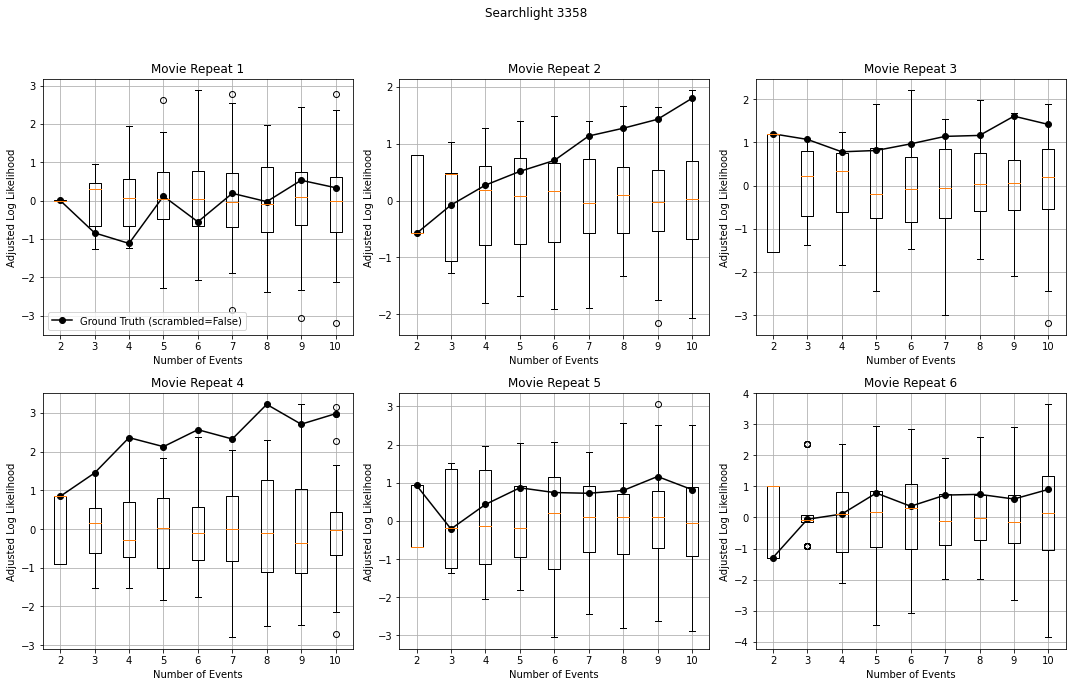

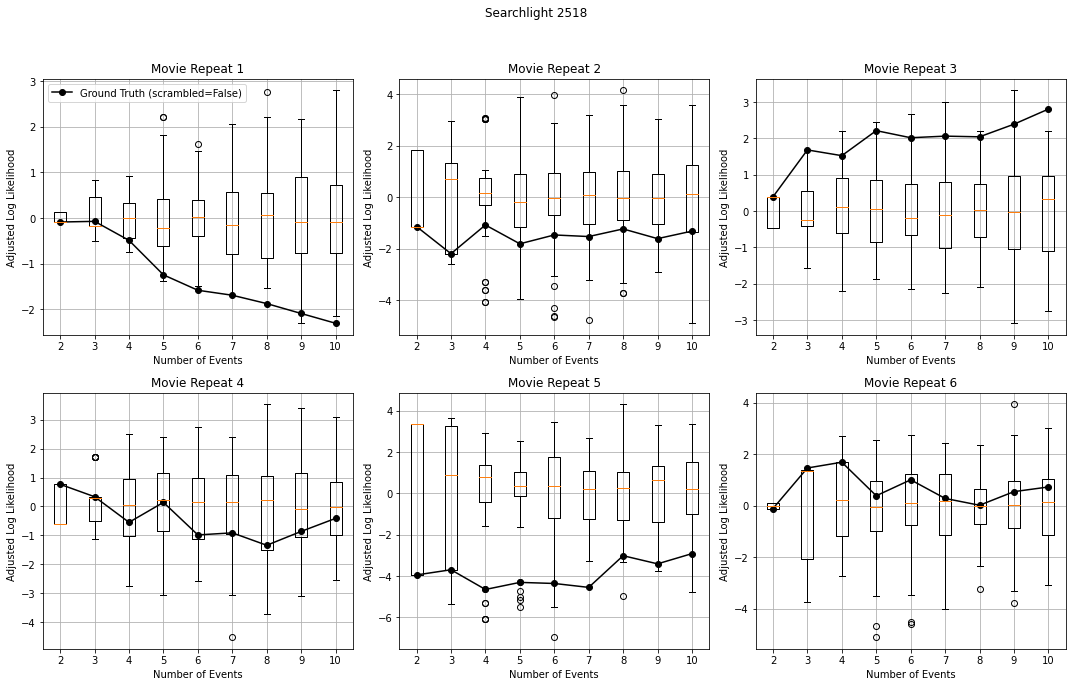

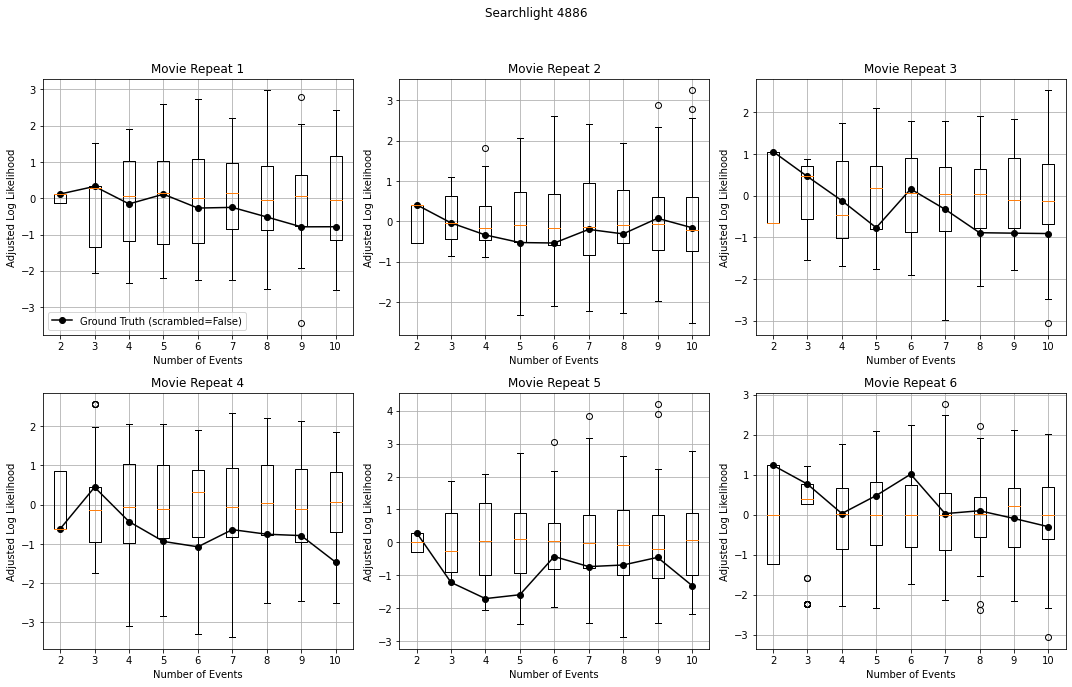

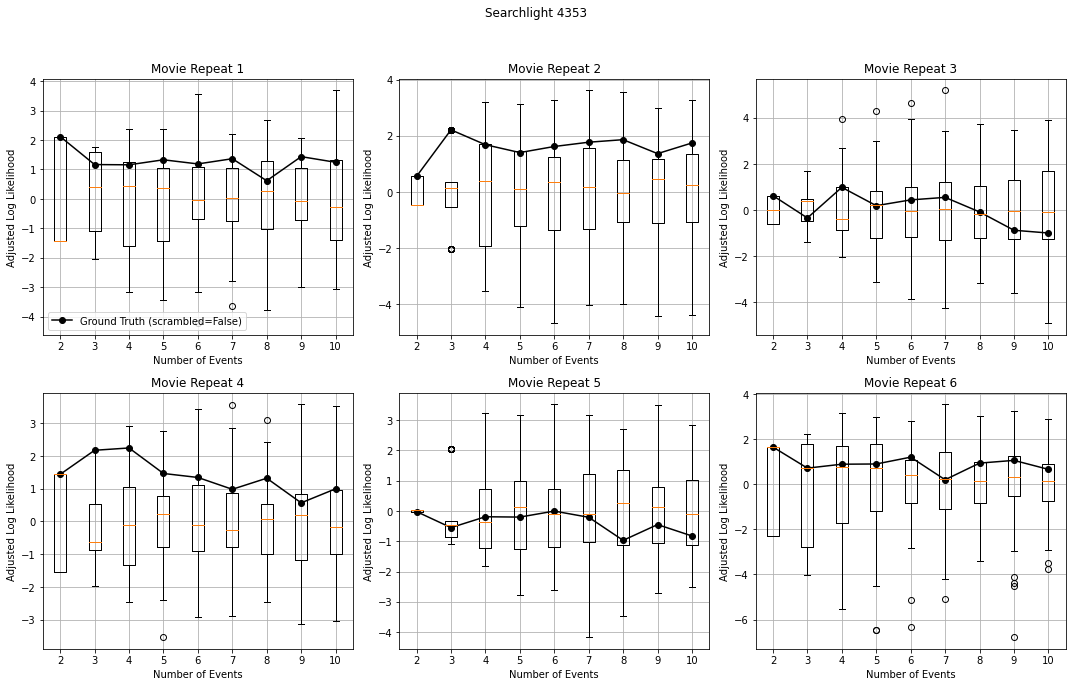

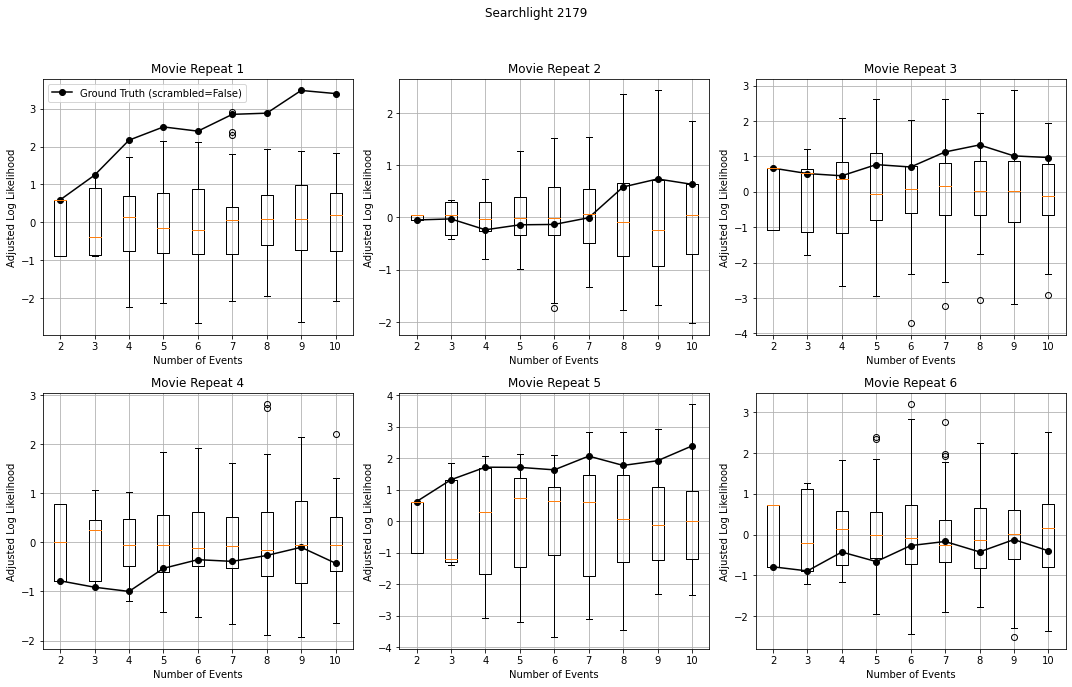

KeyboardInterrupt: 

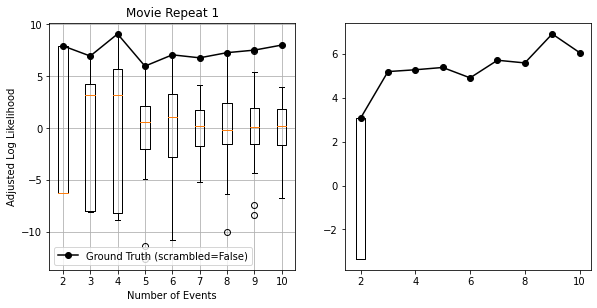

In [10]:
#areas_LLs = np.load(f'./intact_maps/LL/scrambled_ll_no_split.npy', allow_pickle=True)
plot_individual_searchlights(areas_LLs)

## Filter Searchlights

In [18]:
def filter_searchlights(data, threshold=0.01):
    filtered_data = {}

    for sl in data:
        #exclude_searchlight = False

        for repeat in range(6):  # Movie repeats 1 to 6
            true_ll = data[sl][:, repeat, 0]
            null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(np.arange(2, 11)))]

            # Get p-values
            p_values = []
            for ev_i, null_distribution in enumerate(null_ll):
                mean_null = np.mean(null_distribution)
                std_null = np.std(null_distribution)
                real_value = true_ll[ev_i]
                z_score = (real_value - mean_null) / std_null
                p_value = norm.sf(z_score)
                p_values.append(p_value)

            if any(p < threshold for p in p_values):
                filtered_data[sl] = data[sl]  # Keep this SL
                break

    return filtered_data

In [19]:
filtered_sl = filter_searchlights(areas_LLs)

In [20]:
len(filtered_sl.keys())

62

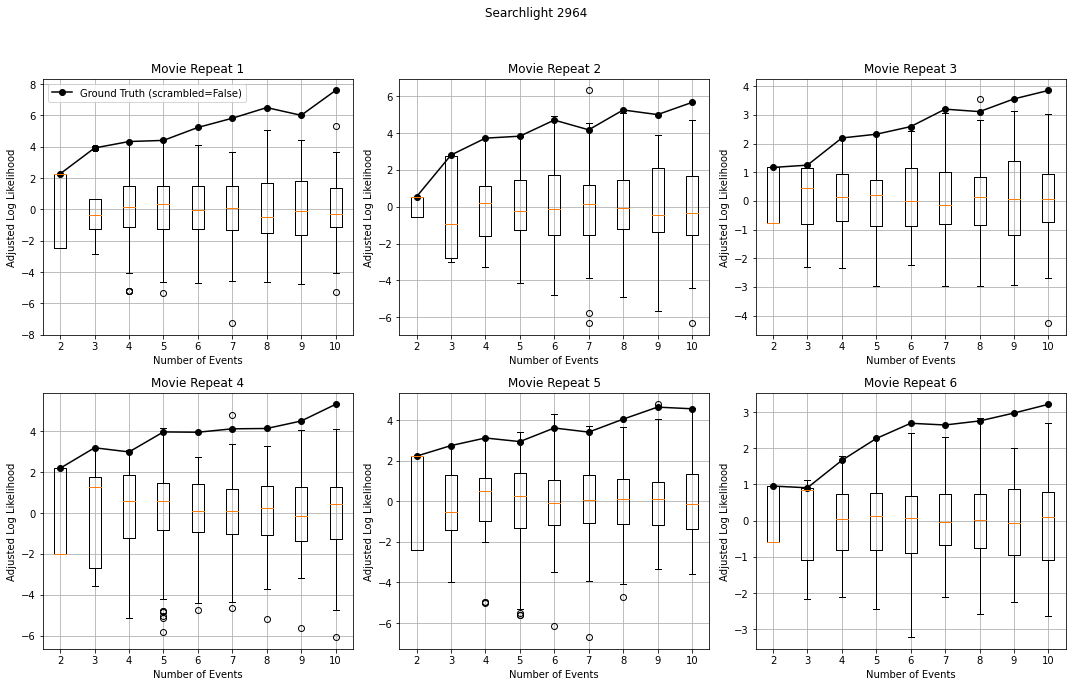

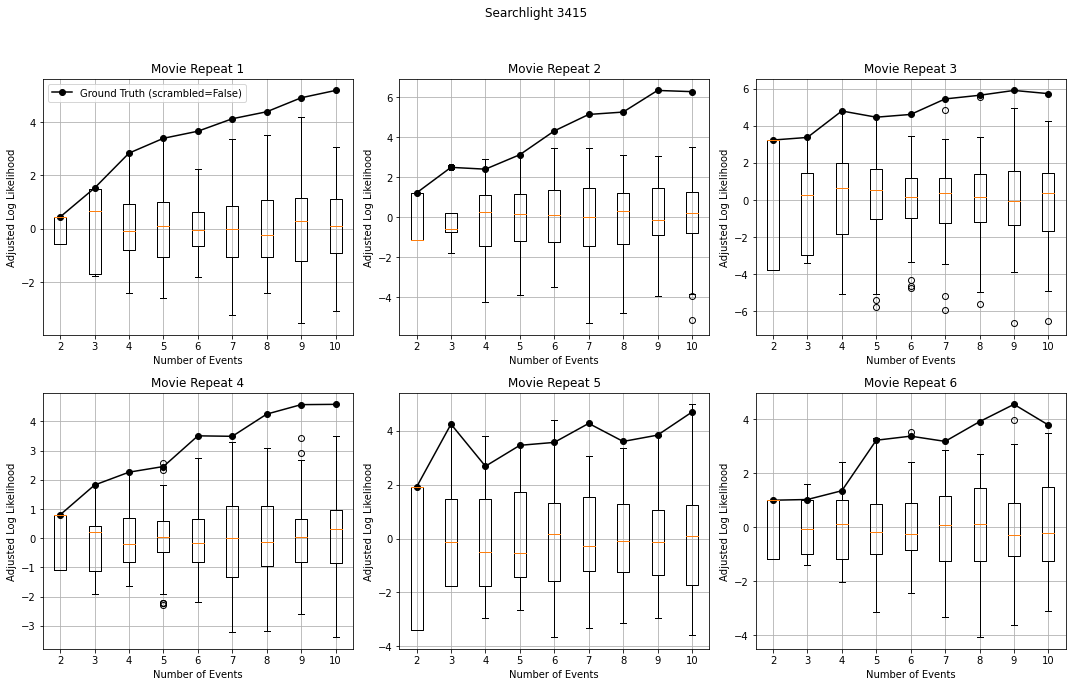

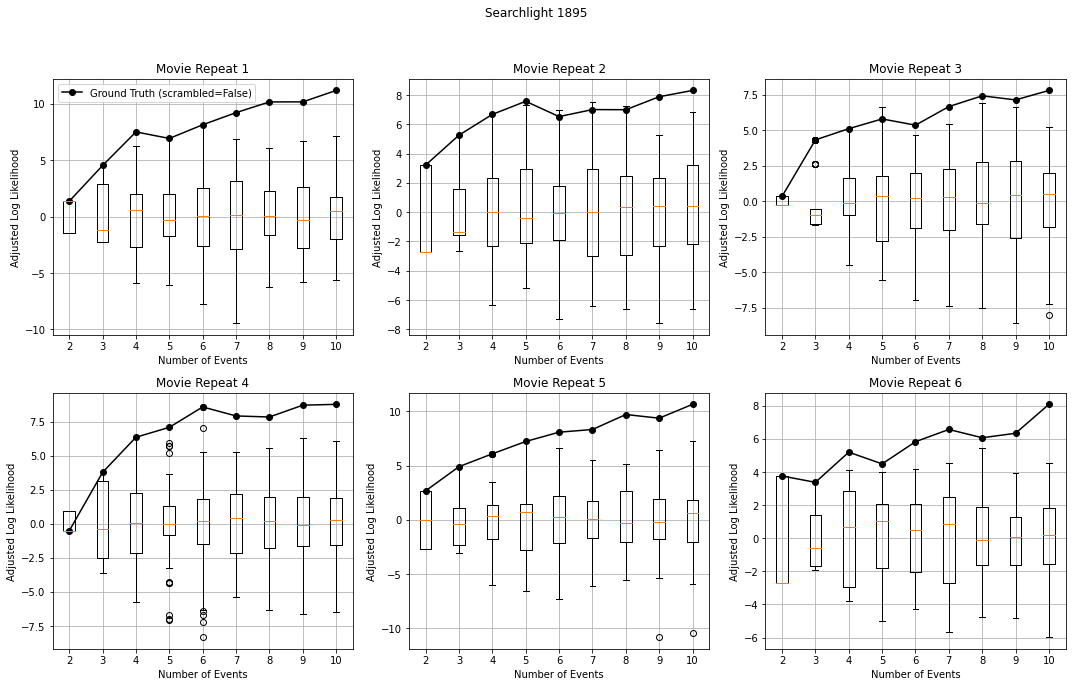

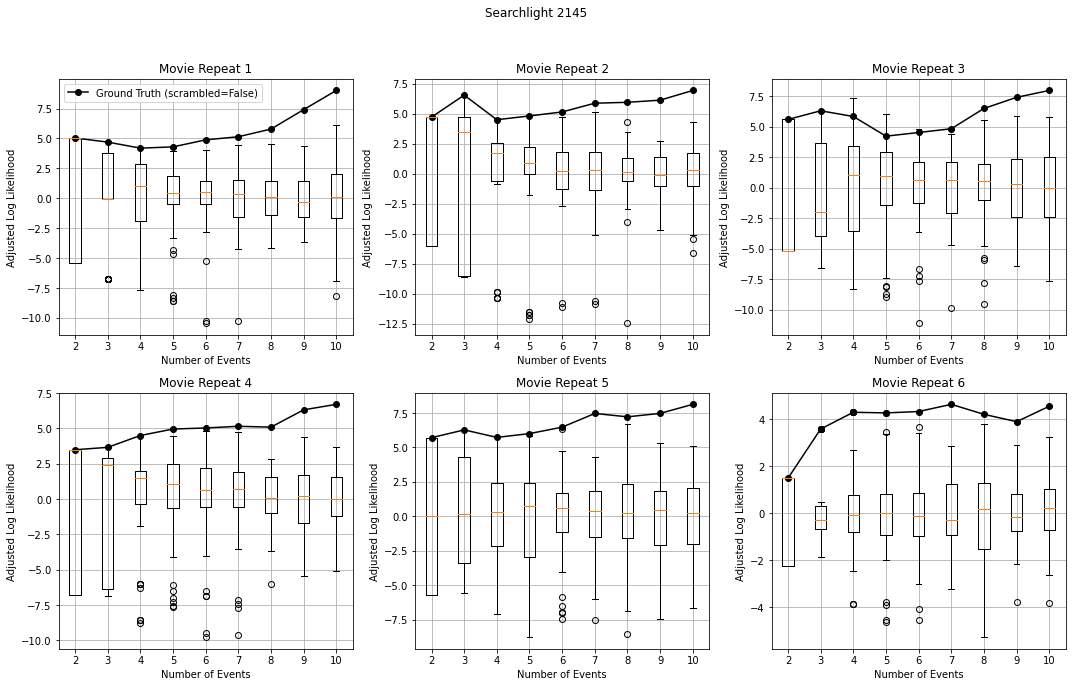

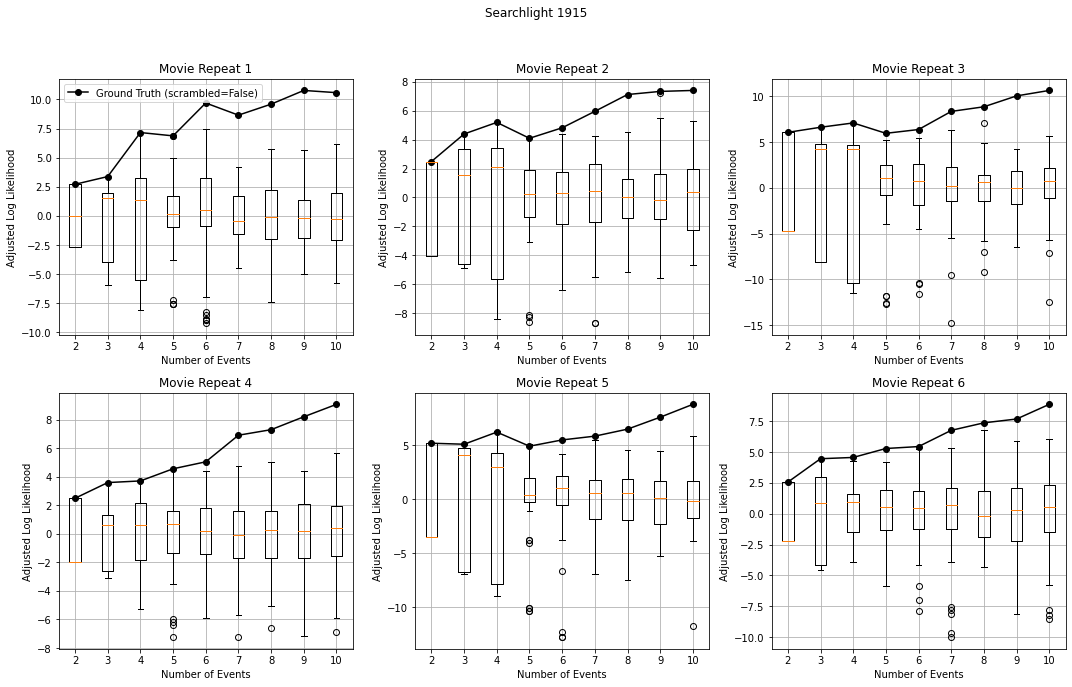

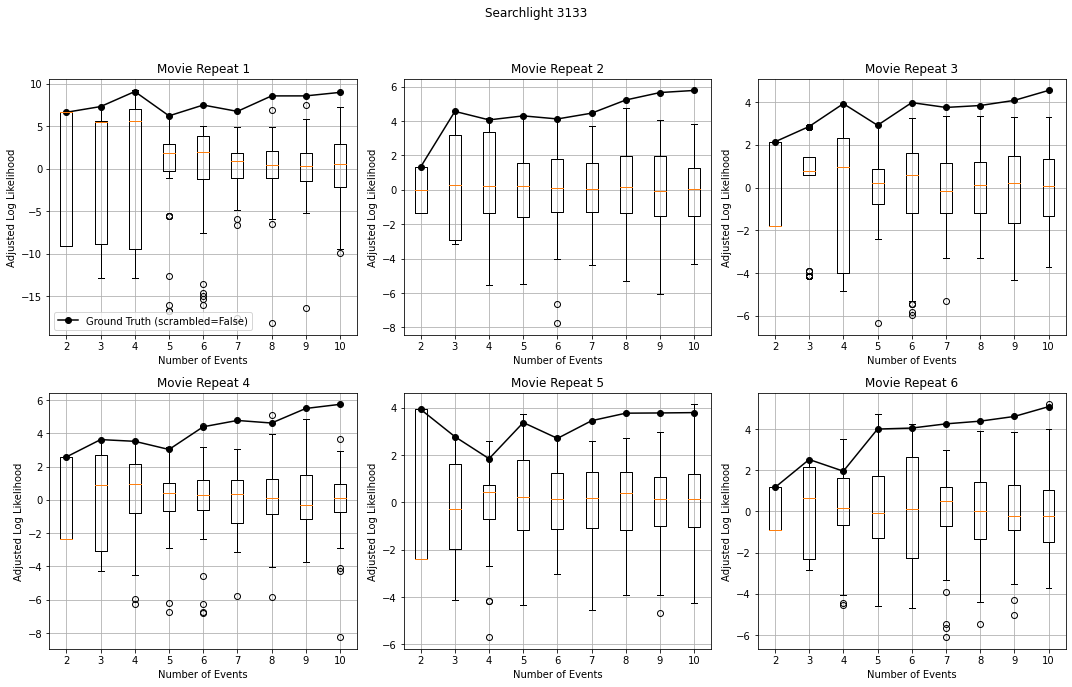

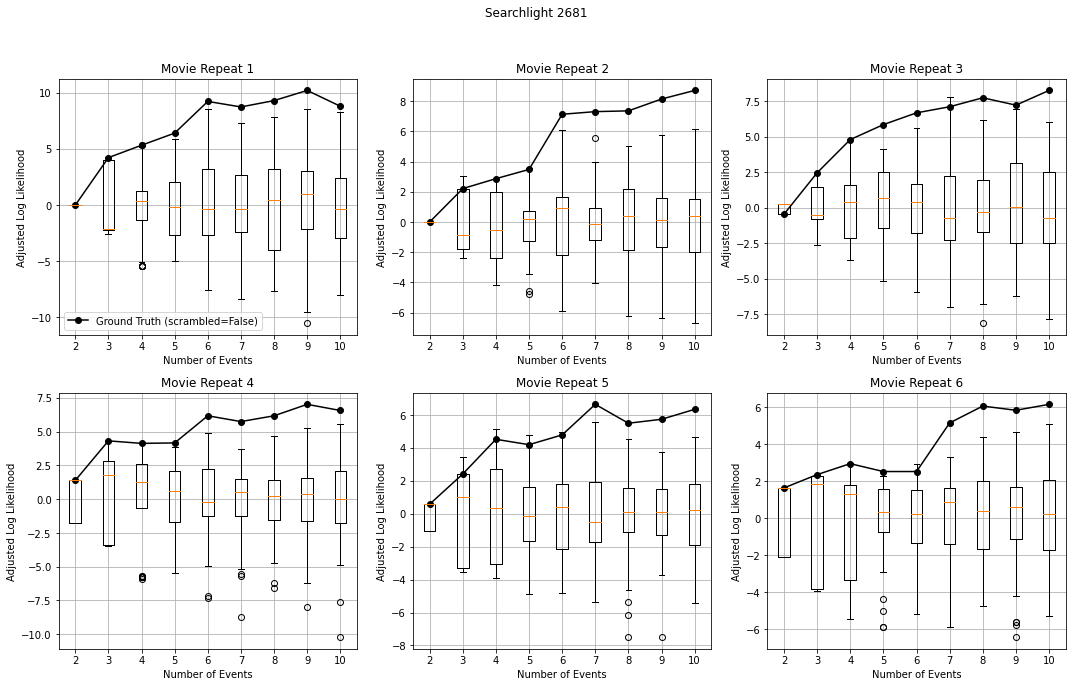

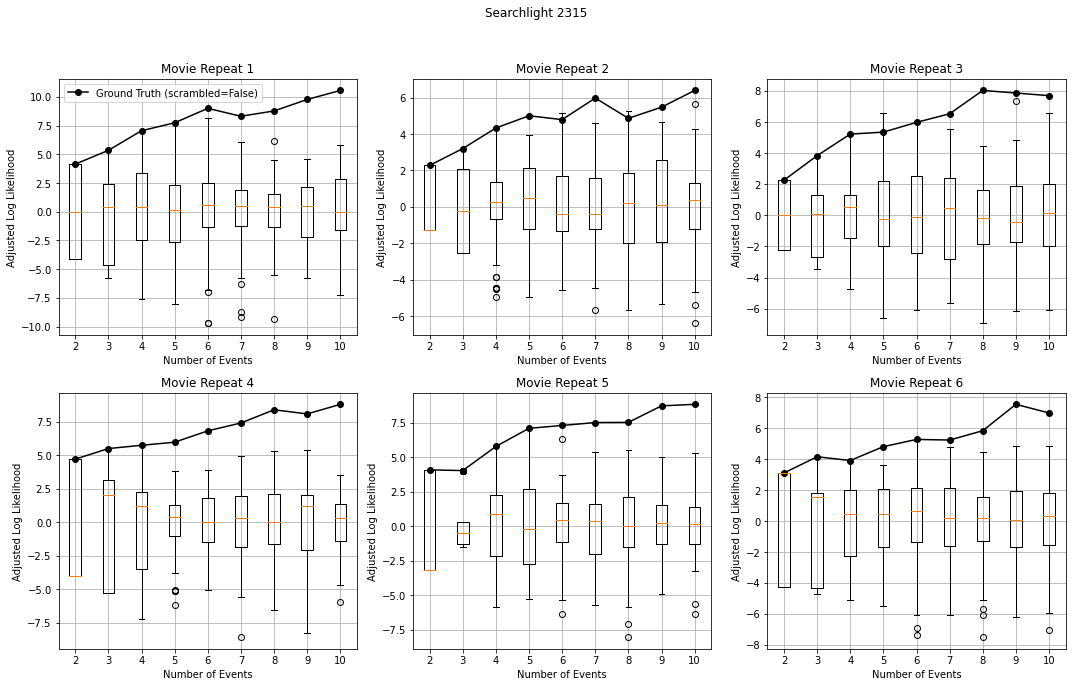

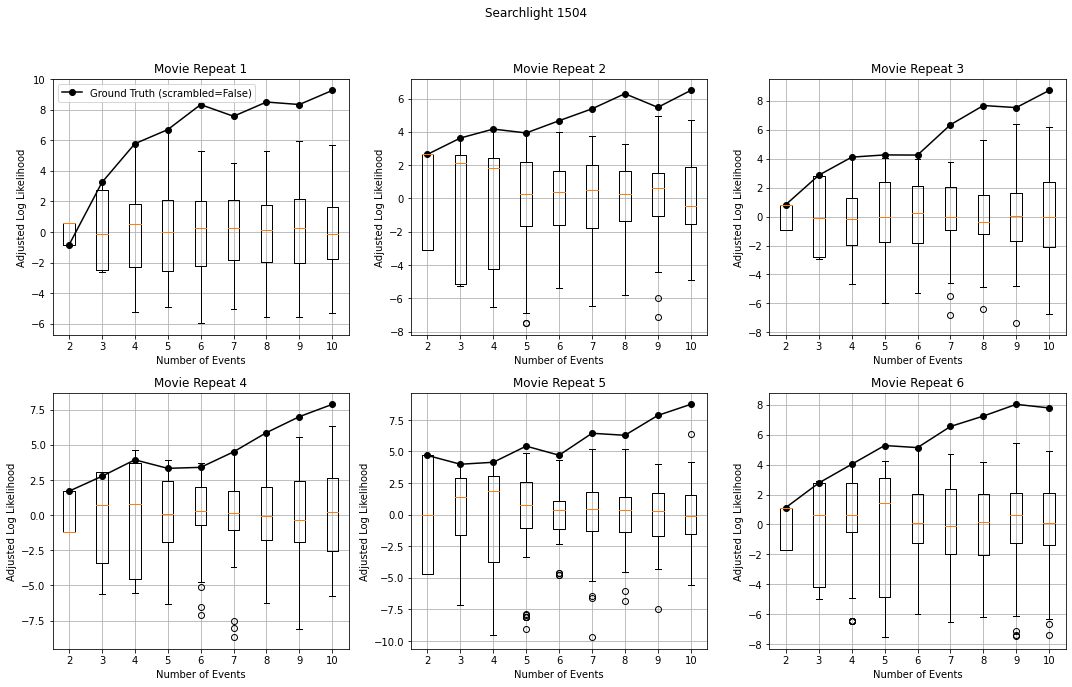

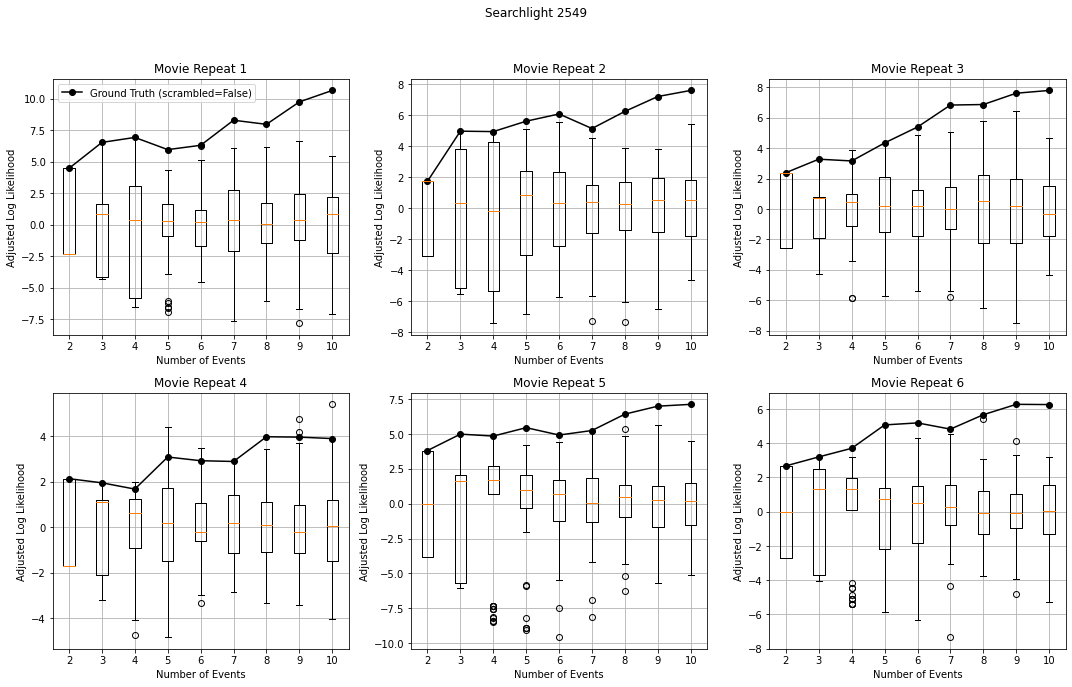

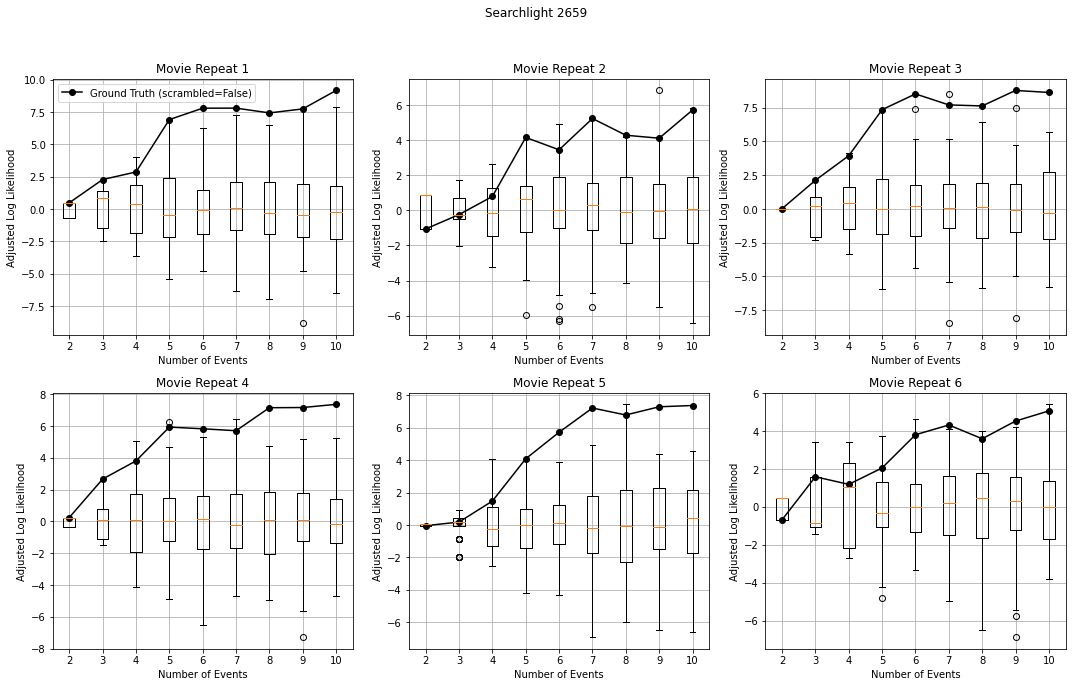

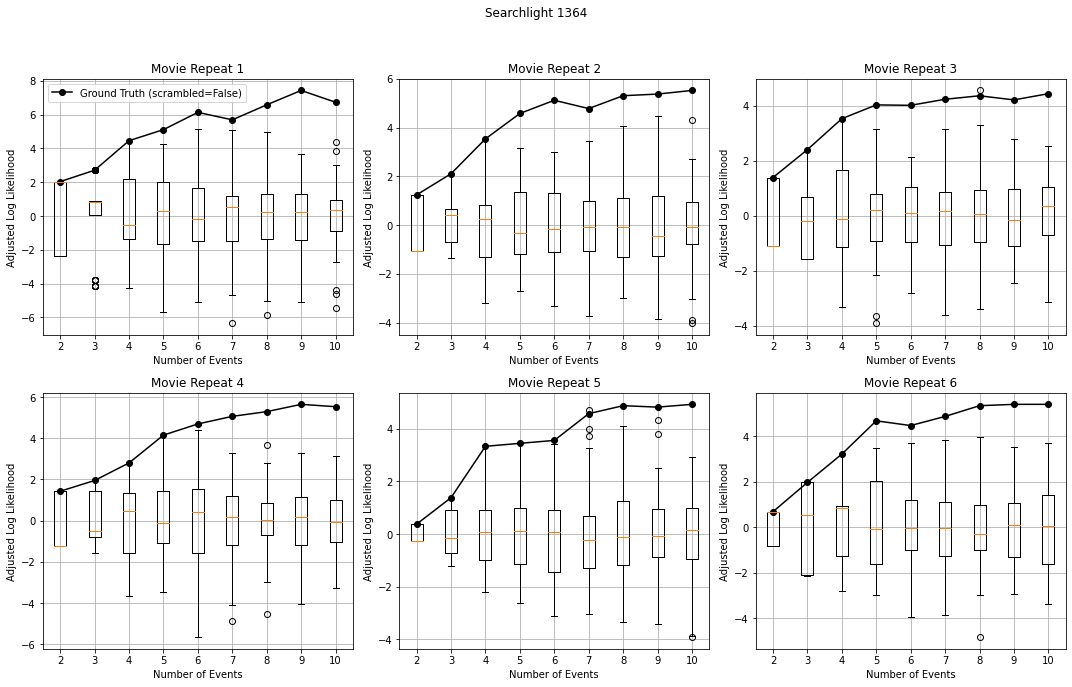

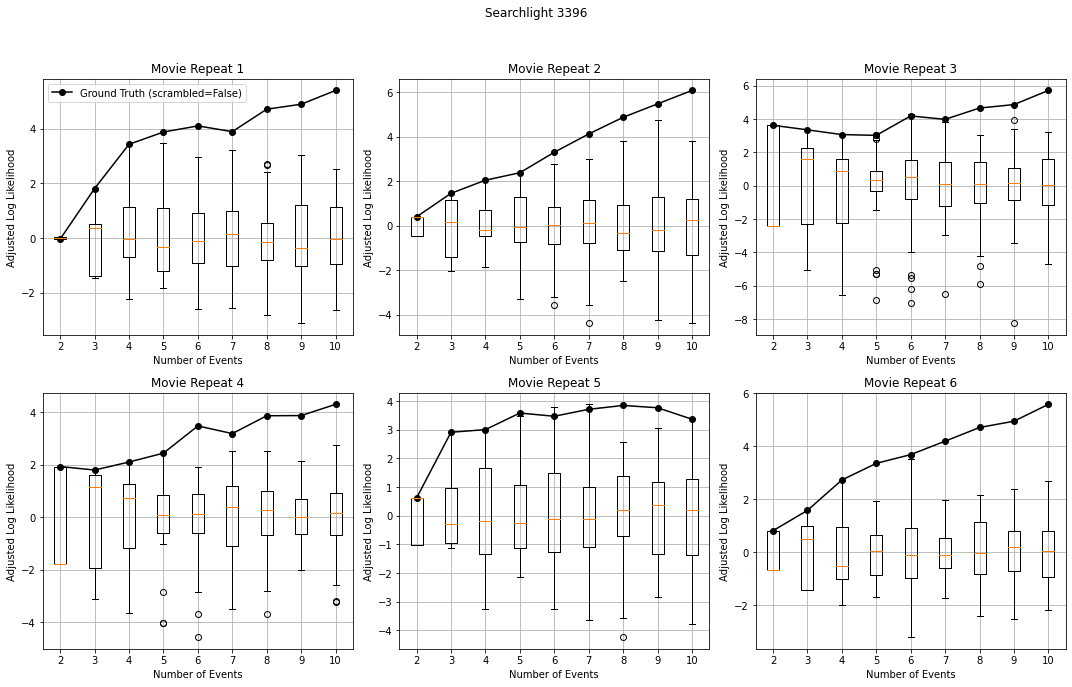

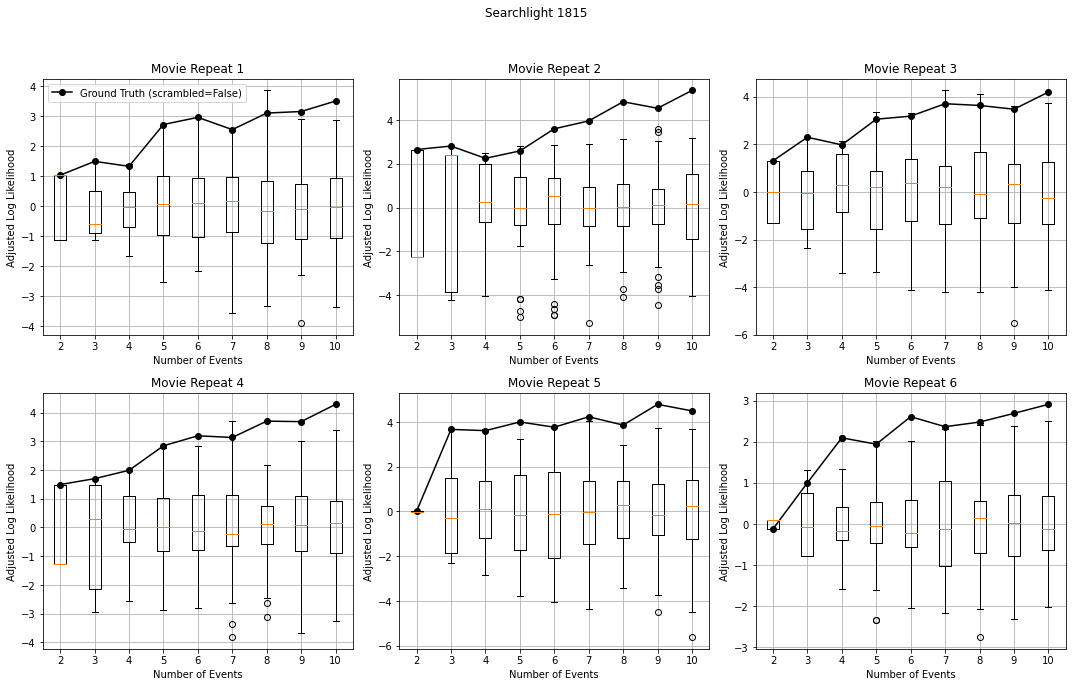

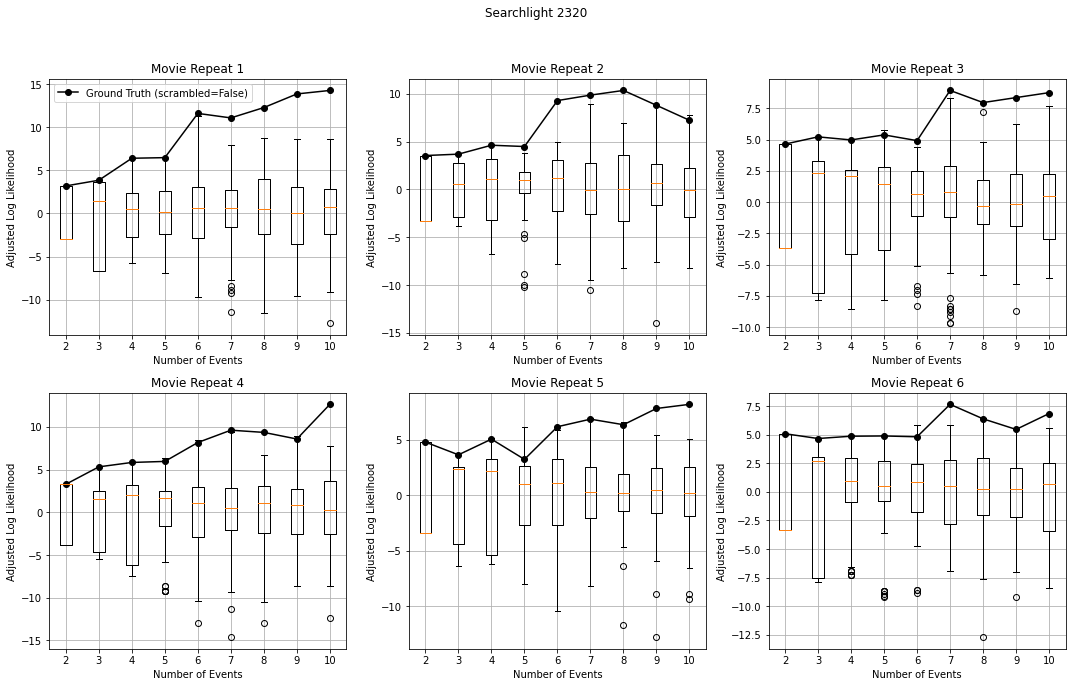

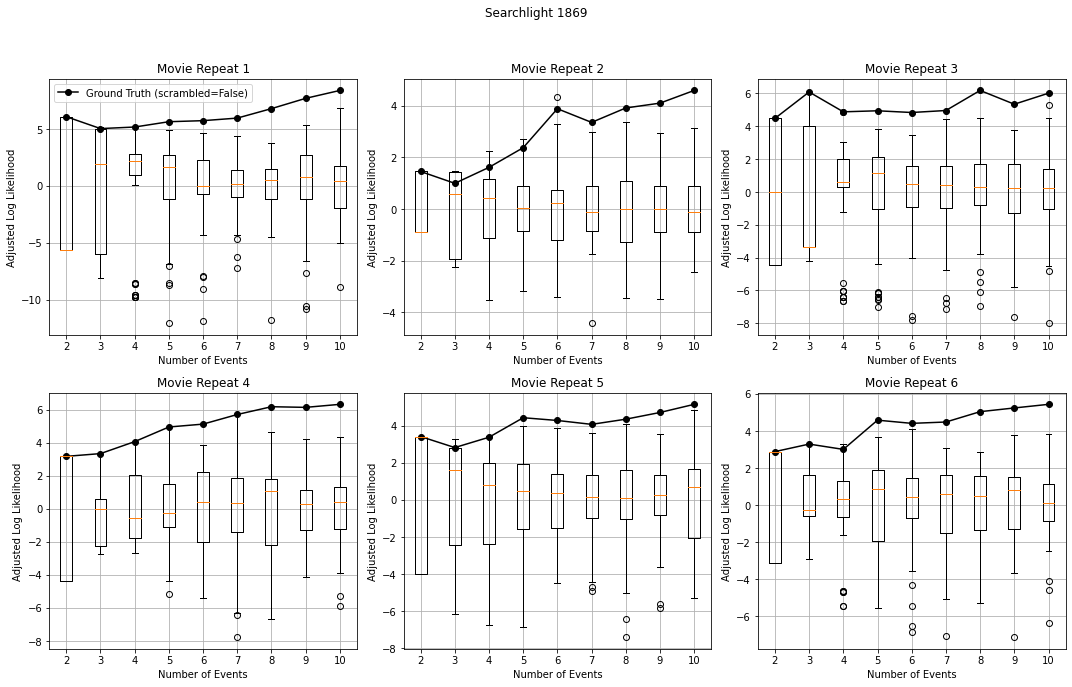

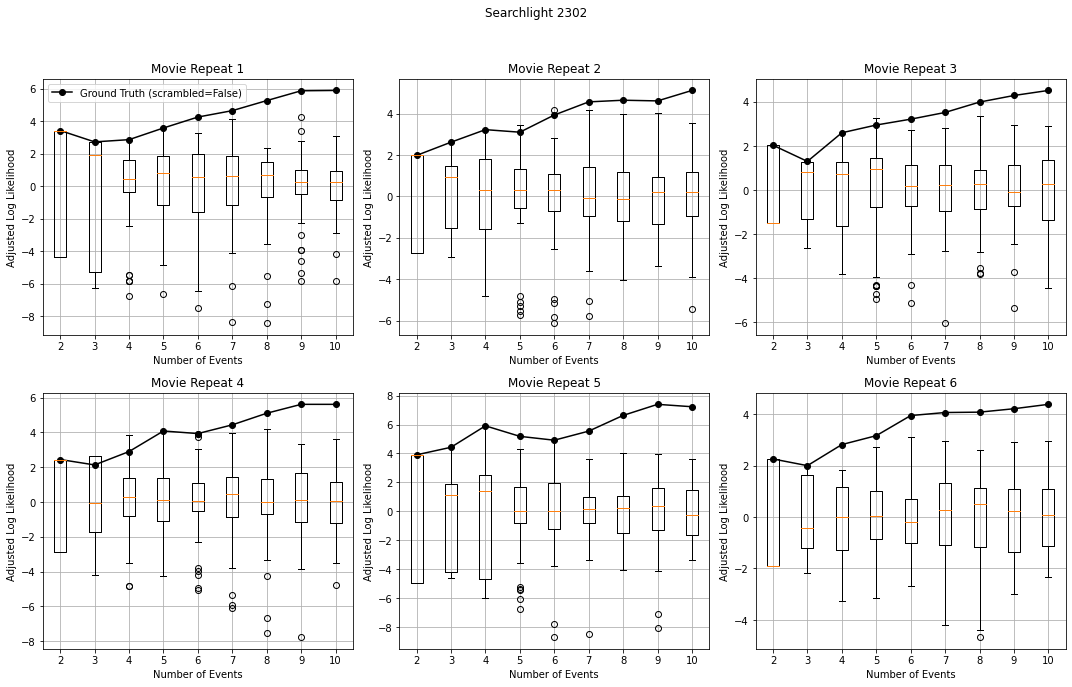

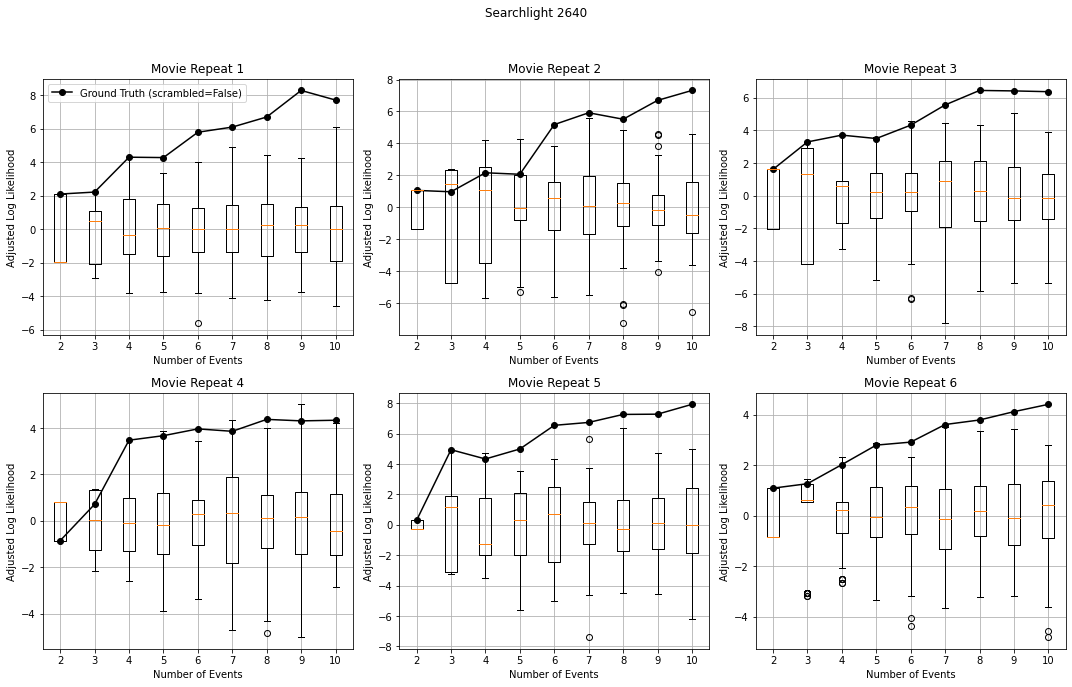

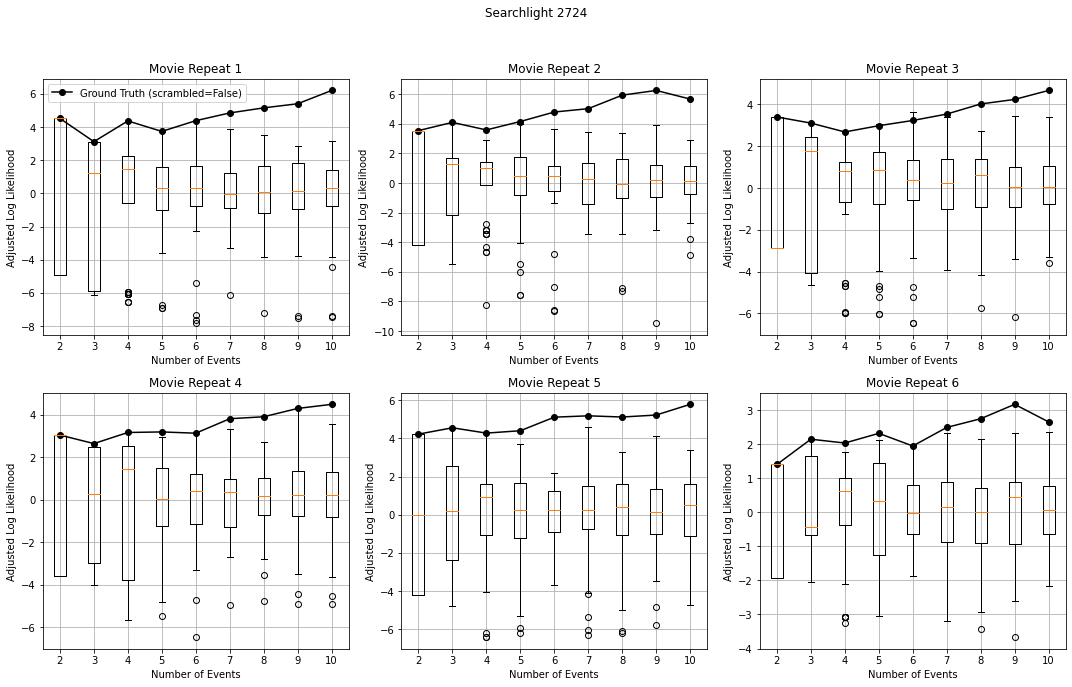

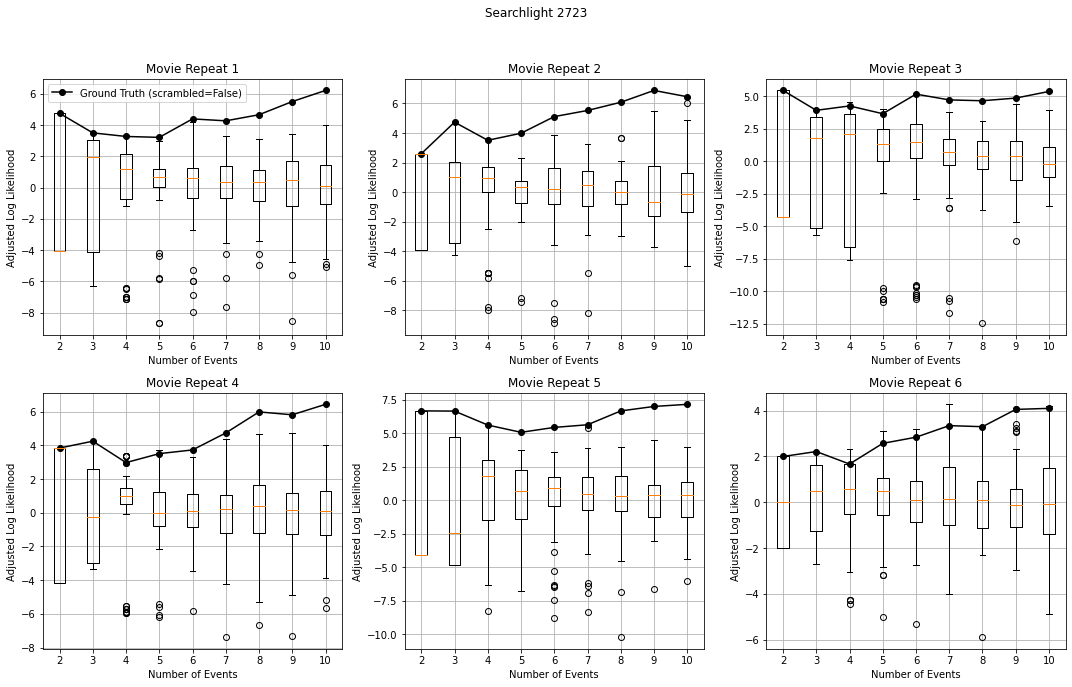

KeyboardInterrupt: 

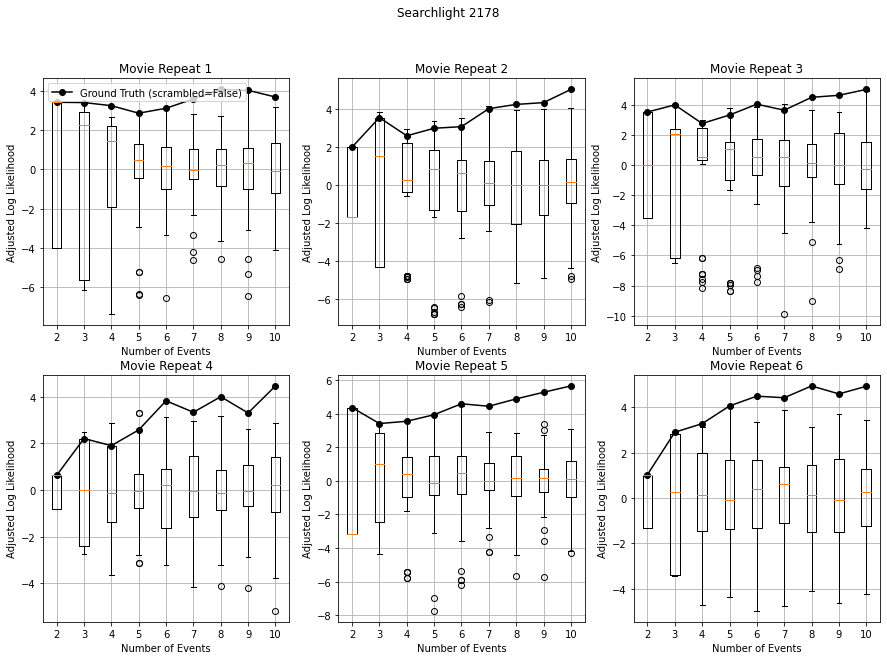

In [21]:
plot_individual_searchlights(filtered_sl)

## Filtered Repeats within SLs

In [ ]:
def get_passing_searchlights_and_repeats(data, threshold=0.01):
    passing_indices = {}

    for sl in data:  # Iterate over each searchlight
        for repeat in range(6):  # Movie repeats 1 to 6
            true_ll = data[sl][:, repeat, 0]
            null_ll = [data[sl][ev_i, repeat, 1] for ev_i in range(len(np.arange(2, 11)))]

            # Compute p-values
            p_values = []
            for ev_i, null_distribution in enumerate(null_ll):
                mean_null = np.mean(null_distribution)
                std_null = np.std(null_distribution)
                real_value = true_ll[ev_i]
                z_score = (real_value - mean_null) / std_null
                p_value = norm.sf(z_score)
                p_values.append(p_value)

            # Check if any p-value is below the threshold
            if any(p < threshold for p in p_values):
                if sl not in passing_indices:
                    passing_indices[sl] = []
                passing_indices[sl].append(repeat)

    return passing_indices

In [ ]:
# Get the indices
passing_indices = get_passing_searchlights_and_repeats(areas_LL)